# Xây dựng mô hình dự đoán

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
import math
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler

In [74]:
df = pd.read_csv("/content/drive/MyDrive/Colab/DATN/data-modeling/data_clean_mongo_ver2.csv")

In [75]:
df = df[~df['ward'].str.contains('Khu đô thị', case=False)]
df = df[~df['province'].str.contains('lộ', case=False)]
df['ward'] = df['ward'].str.replace('phường','').str.strip()
df['ward'] = df['ward'].str.replace('hường','').str.strip()
df['ward'] = df['ward'].str.replace('huyện','').str.strip()
df['ward'] = df['ward'].str.replace('Huyện','').str.strip()
province_counts = df['province'].value_counts()
unique_province_values = province_counts[province_counts == 1].index

# Xóa bỏ các hàng có giá trị trong cột "province" thuộc danh sách các giá trị duy nhất có số lượng là 1
df = df[~df['province'].isin(unique_province_values)]

ward_counts = df['ward'].value_counts()
unique_ward_values = ward_counts[ward_counts == 1].index

# Xóa bỏ các hàng có giá trị trong cột "ward" thuộc danh sách các giá trị duy nhất có số lượng là 1
df = df[~df['ward'].isin(unique_ward_values)]

district_counts = df['district'].value_counts()
unique_district_values = district_counts[district_counts == 1].index

# Xóa bỏ các hàng có giá trị trong cột "district" thuộc danh sách các giá trị duy nhất có số lượng là 1
df = df[~df['district'].isin(unique_district_values)]

Xử lý trường giá (Price)

In [76]:
df = df[df['price'].notna()]
df=(df[df.price < 1.5e10])
df.reset_index(drop=True, inplace=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x7edfa9e60fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7edfa9e61510>,
 'boxes': [<matplotlib.lines.Line2D at 0x7edfa9e60d30>],
 'medians': [<matplotlib.lines.Line2D at 0x7edfa9e61a50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7edfa9e61cf0>],
 'means': []}

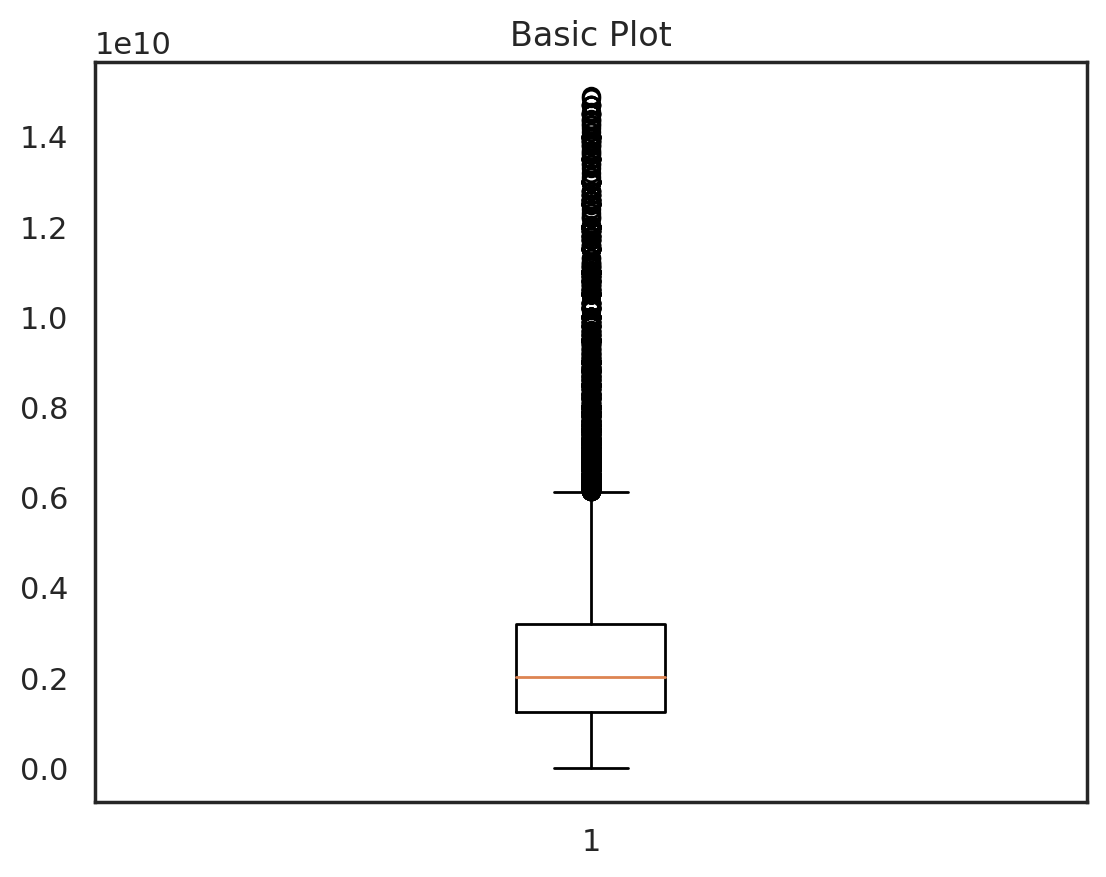

In [77]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(df['price'])


 mu = 2531651026.37 and sigma = 2090821486.82



Text(0.5, 1.0, 'SalePrice distribution')

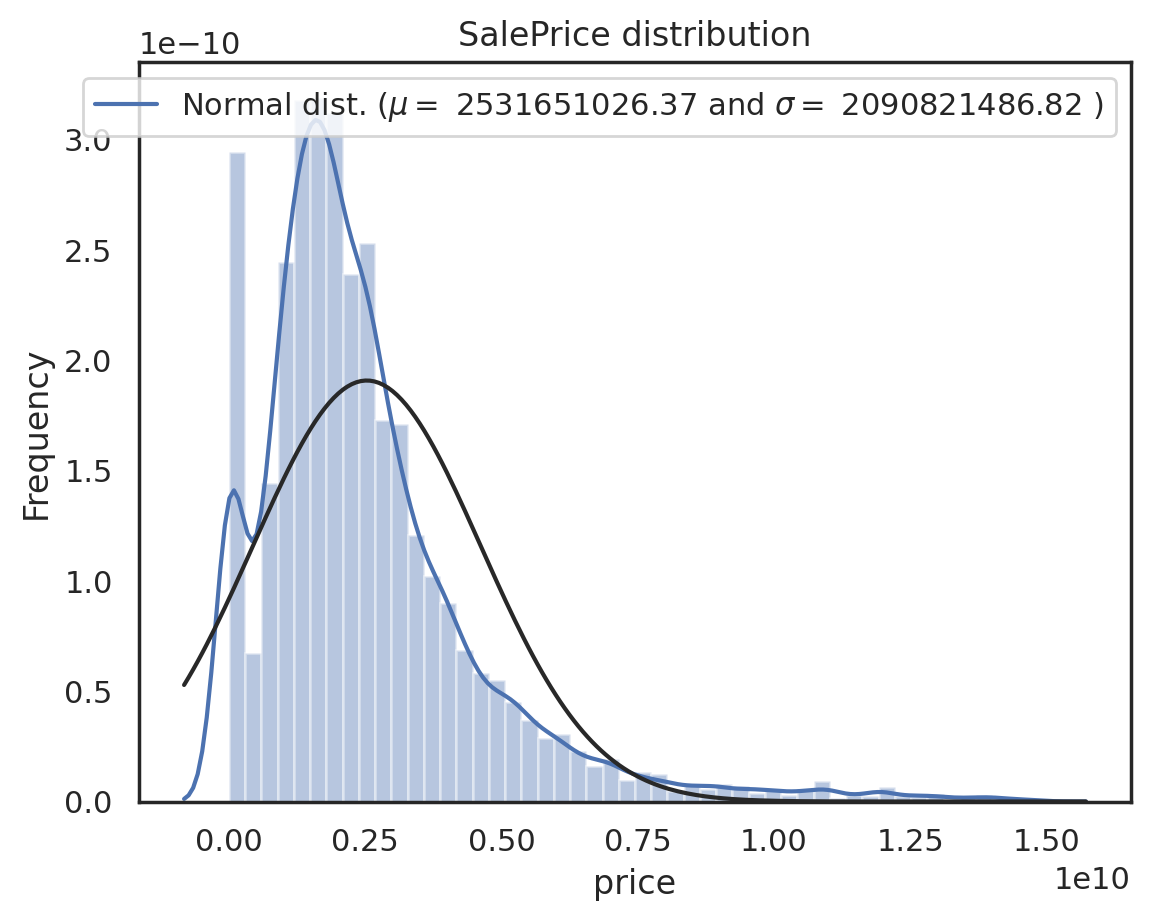

In [78]:
sns.distplot(df['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


Xử lý trường diện tích (square)

In [79]:
df.drop(df[df['square'] > 180].index, inplace=True)
df=(df[df.square > 0])
df.reset_index(drop=True, inplace=True)

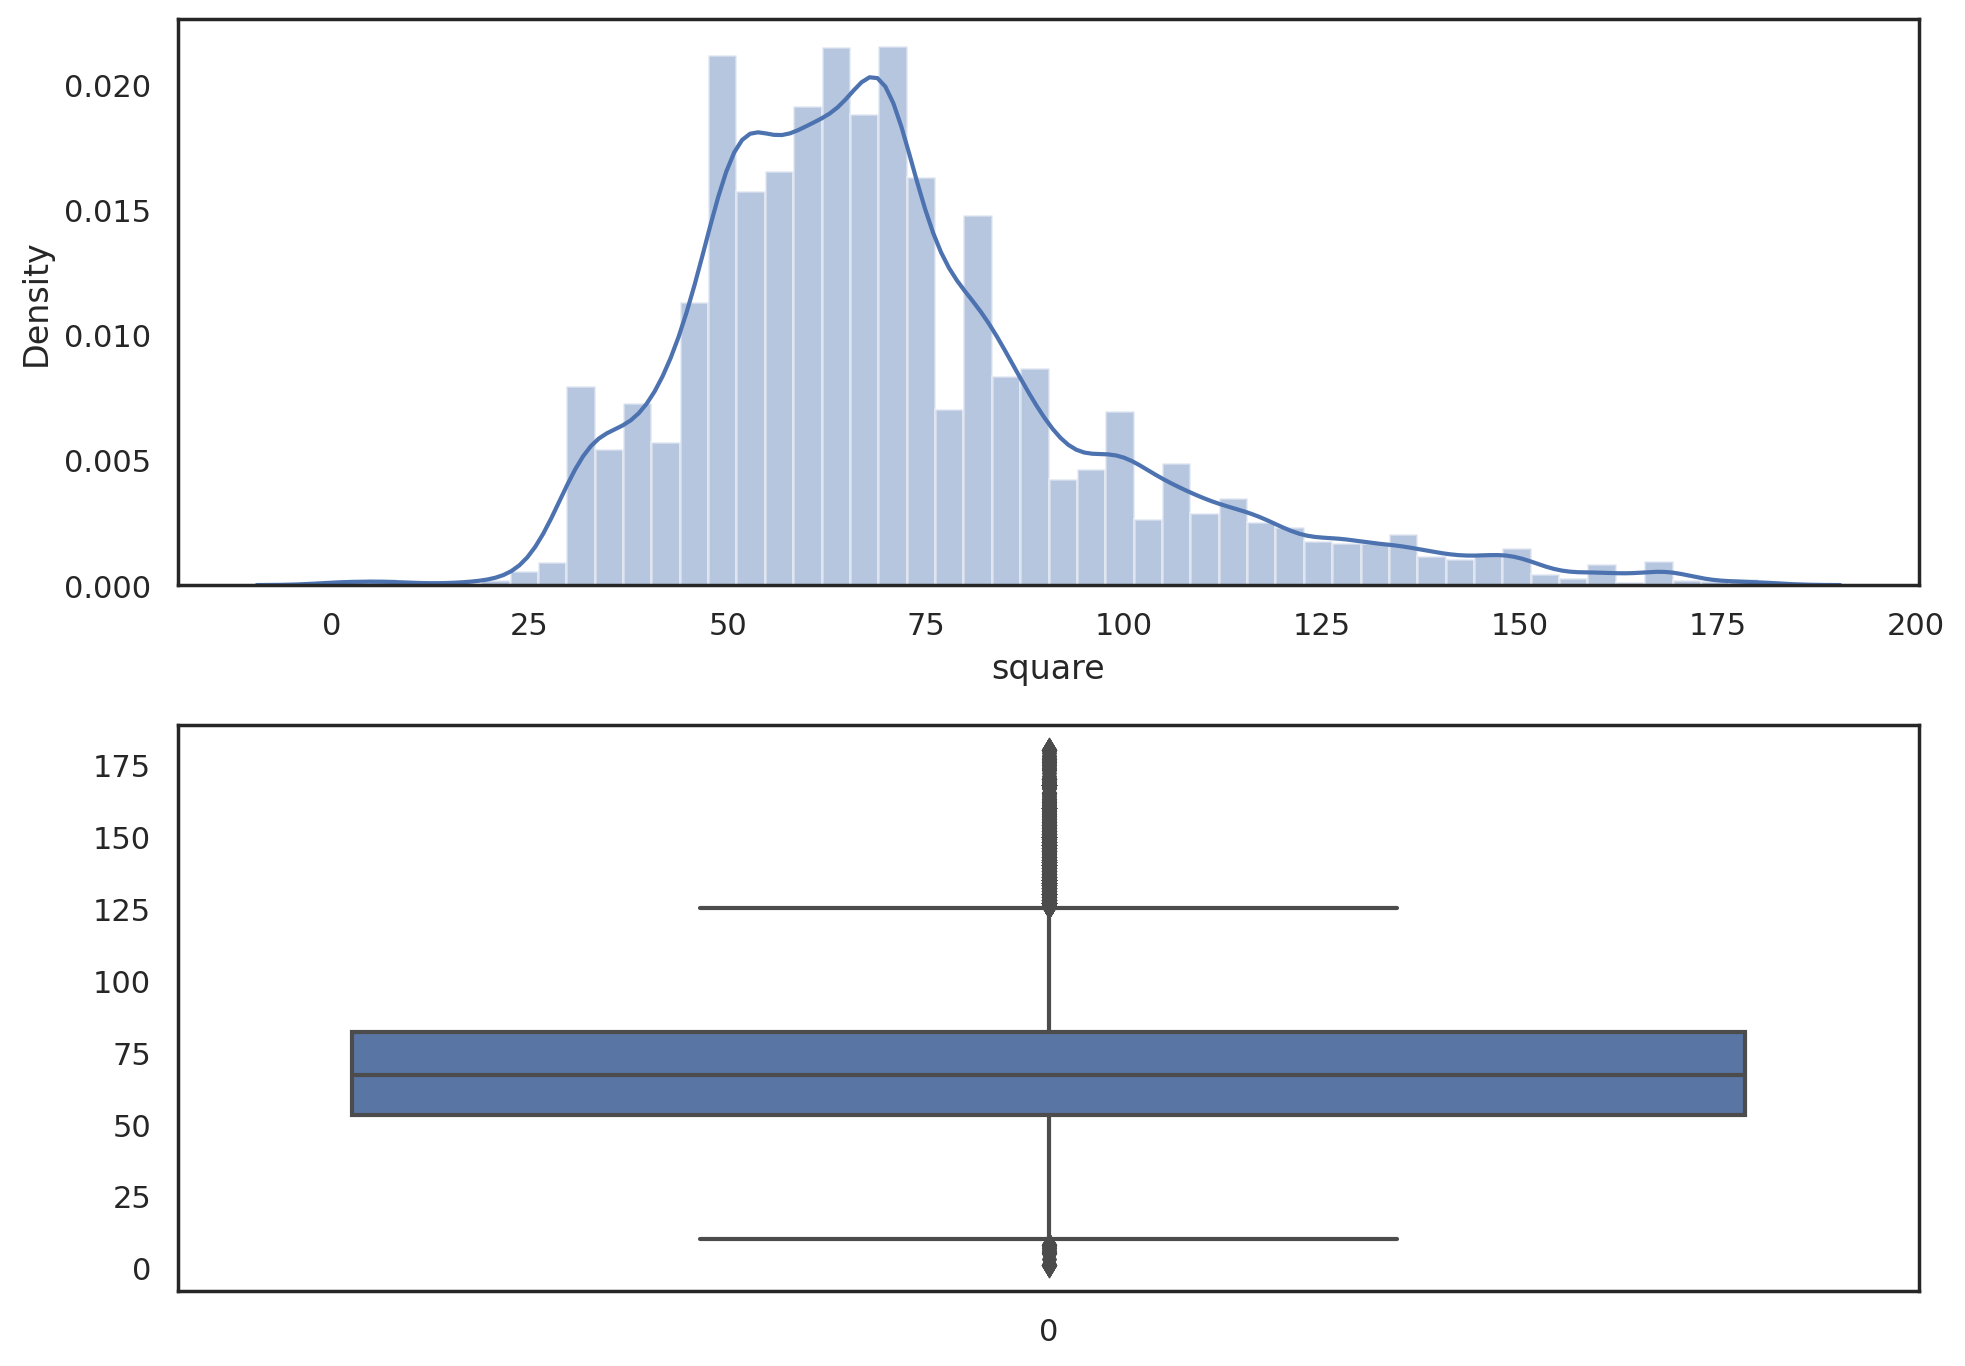

In [80]:
fig = plt.figure(figsize=(10,7))
fig.add_subplot(2,1,1)
sns.distplot(df['square'])
fig.add_subplot(2,1,2)
sns.boxplot(df['square'])
plt.tight_layout()


 mu = 71.14 and sigma = 26.37



Text(0.5, 1.0, 'SalePrice distribution')

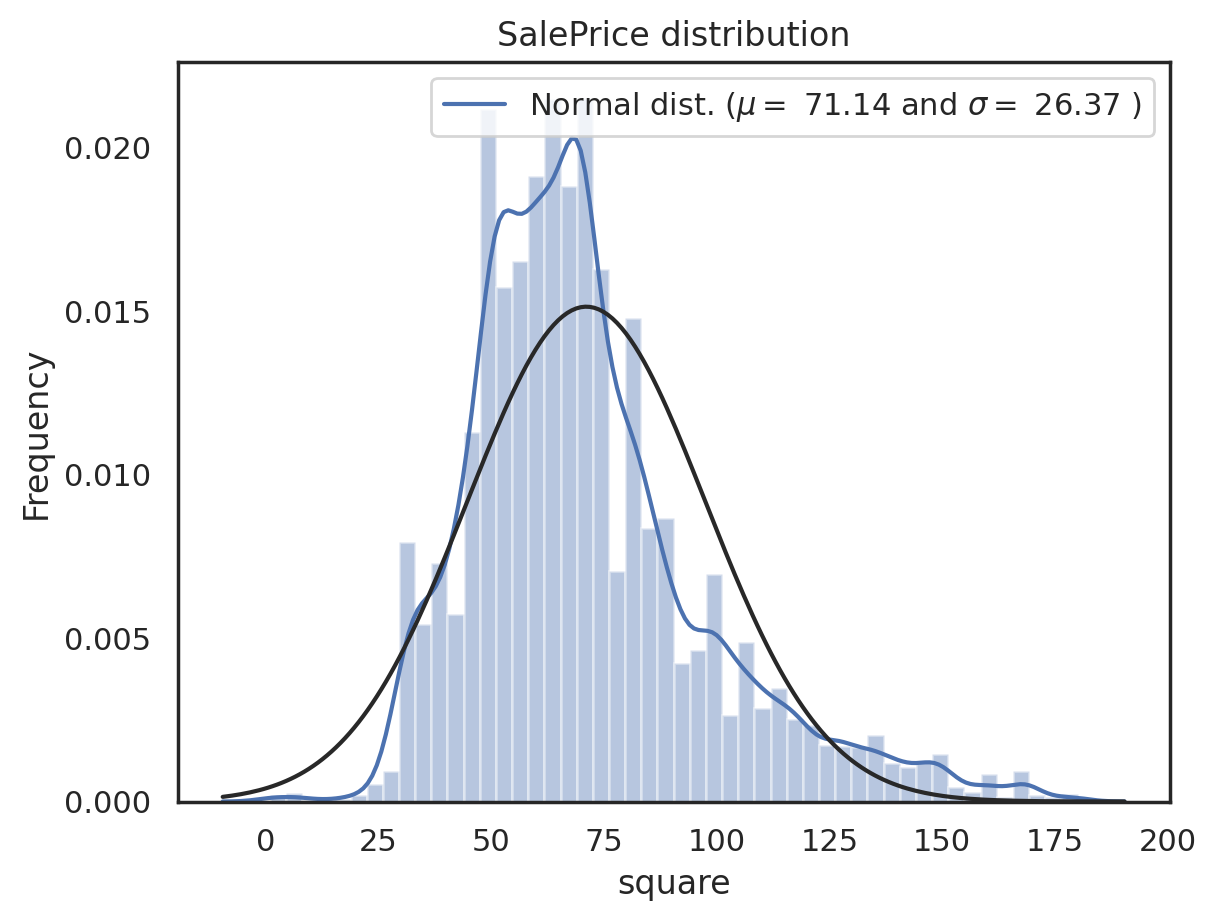

In [81]:
sns.distplot(df['square'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['square'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

In [93]:
df1 = df

Xử lý trường tầng (floor)

In [95]:
# Thay thế bản ghi bị null bằng giá trị trung bình của tập dữ liệu
floor_mean = df1.loc[(df1['floor'] != 0) & (df1['floor'] != 1), 'floor'].mean()
floor_mean_rounded = math.ceil(floor_mean)
df1['floor'] = df1['floor'].apply(lambda x: floor_mean_rounded if x == 0 else x)
df1['floor'] = df1['floor'].apply(lambda x: floor_mean_rounded if x == 1 else x)
df1['floor'].fillna(floor_mean_rounded, inplace=True)

In [96]:
df1=(df1[df1.floor < 50])
df1.reset_index(drop=True, inplace=True)
df1 = df1[df1.floor != 0]


 mu = 5.15 and sigma = 7.66



Text(0.5, 1.0, 'SalePrice distribution')

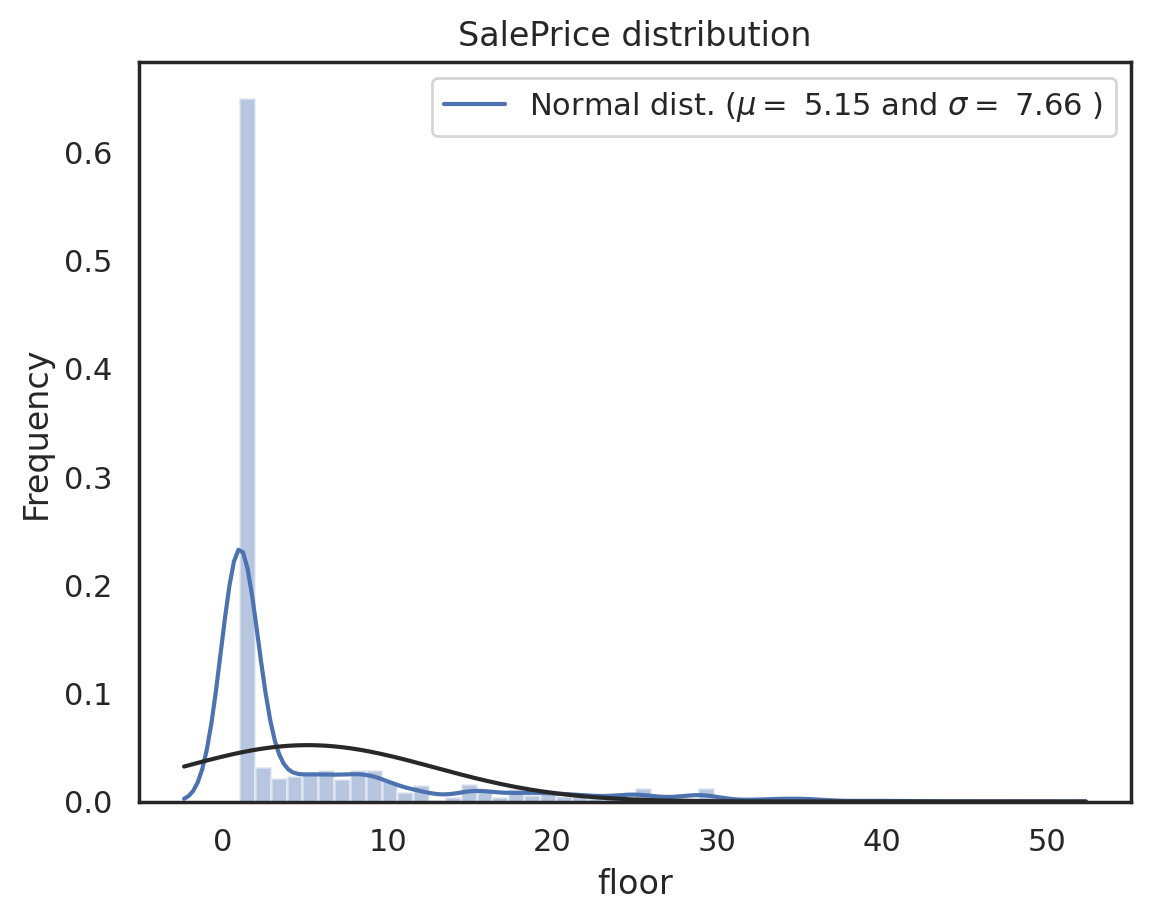

In [87]:
sns.distplot(df1['floor'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df1['floor'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

Xử lý trường phòng ngủ, phòng tắm (bedroom, bathroom)

In [97]:
# Thay thế các giá trị bị thiếu của bedroom hoặc bathroom bằng các giá trị trung bình của tâp
bedroom_mean = df1['bedroom'].mean()
bedroom_mean_rounded = math.ceil(bedroom_mean)
df1['bedroom'].fillna(bedroom_mean_rounded, inplace=True)
bathroom_mean = df1.loc[(df1['bathroom'] != 0), 'bathroom'].mean()
bathroom_mean_rounded = math.ceil(bathroom_mean)
df1['bathroom'].fillna(bathroom_mean_rounded, inplace=True)

In [98]:
# Loại bỏ các bản ghi có số phòng ngủ, phòng tắm quá 15
df1=(df1[df1.bedroom < 15])
df1.reset_index(drop=True, inplace=True)
df1=(df1[df1.bathroom < 15])
df1.reset_index(drop=True, inplace=True)


 mu = 1.99 and sigma = 0.95



Text(0.5, 1.0, 'SalePrice distribution')

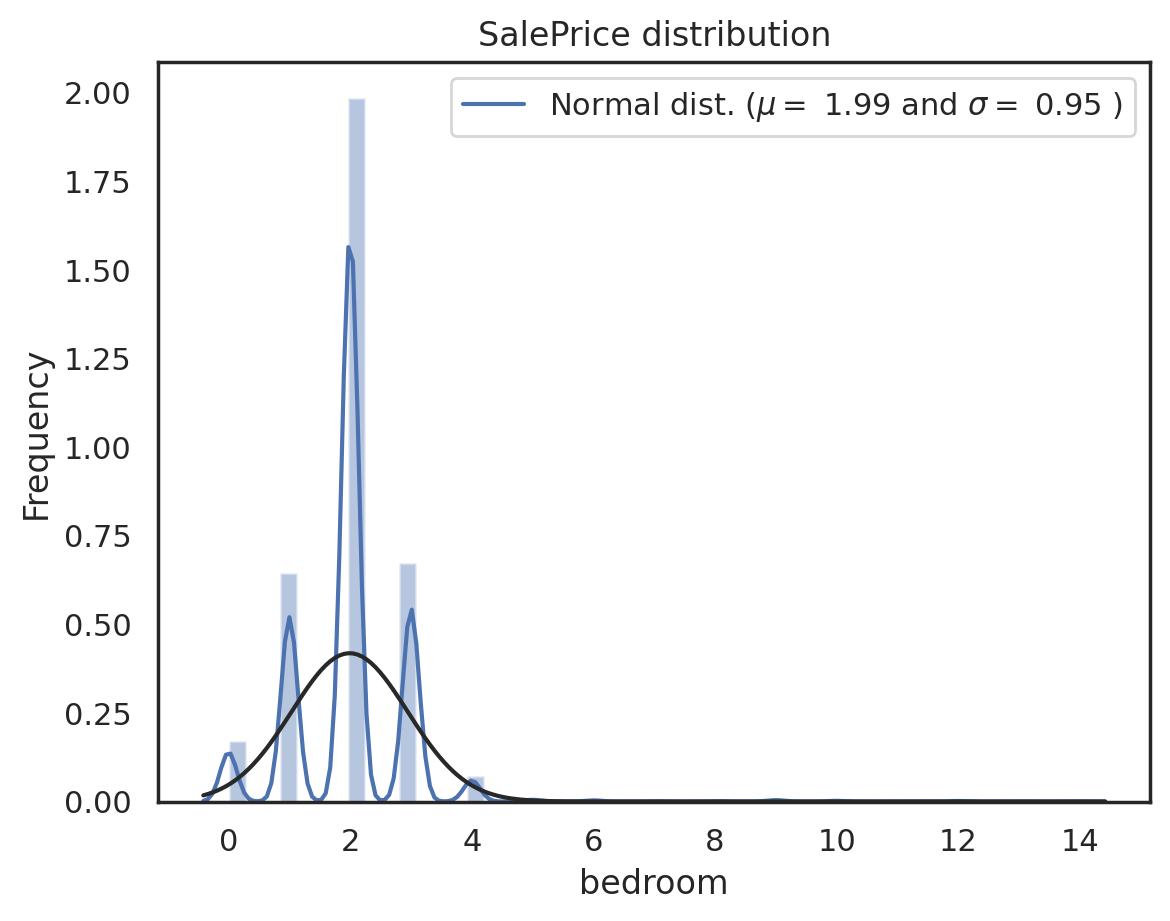

In [90]:
sns.distplot(df1['bedroom'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df1['bedroom'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


 mu = 1.99 and sigma = 0.95



Text(0.5, 1.0, 'SalePrice distribution')

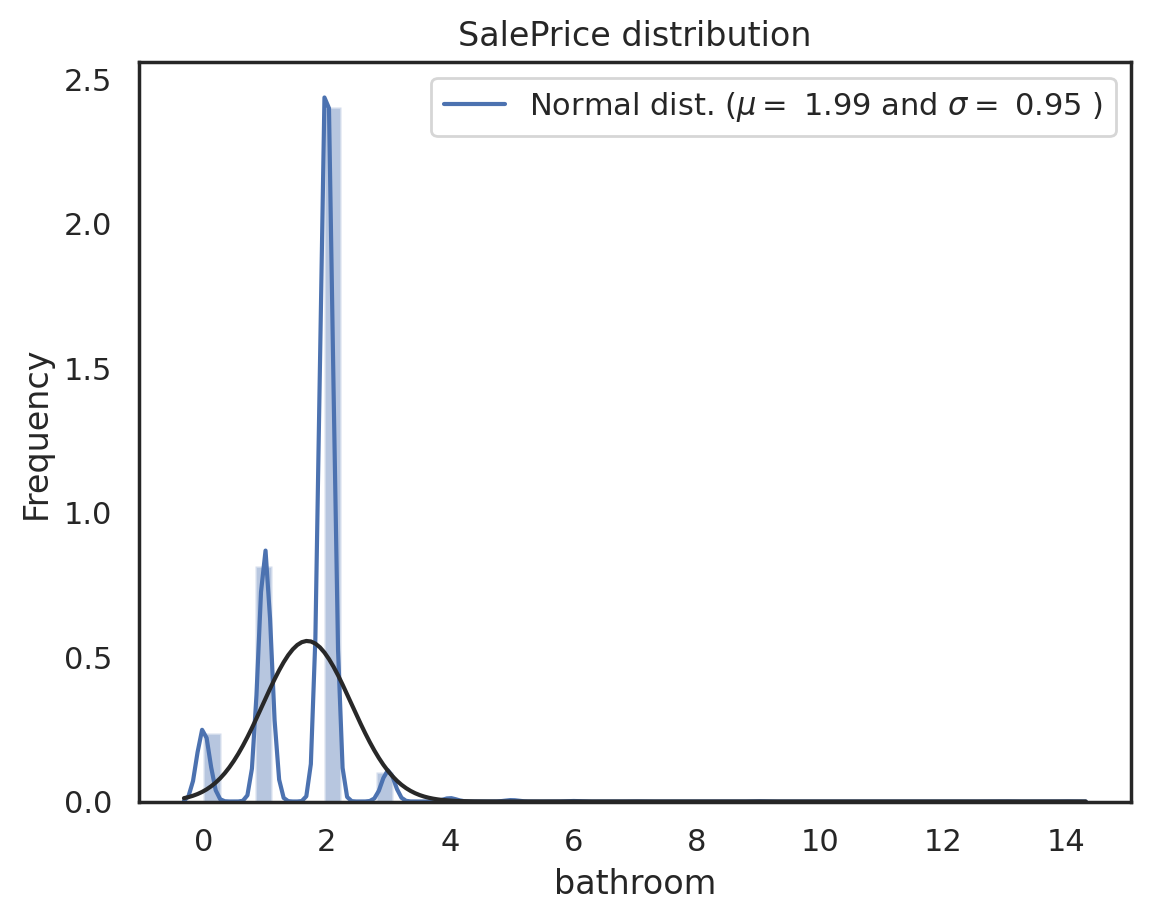

In [91]:
sns.distplot(df1['bathroom'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df1['bedroom'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

Dữ liệu sau cùng dùng để train mô hình

In [99]:
df1.shape

(25163, 31)

Chọn các trường square, floor, bathroom, bedroom, district, province, ward, price dùng để train mô hình

In [101]:
df_meaning = df1[['square','floor', 'bathroom', 'bedroom', 'district', 'province', 'ward', 'price']]

In [107]:
# Chỉ lấy cái bản ghi có giá hơn 100 triệu để train mô hình
df_meaning = df_meaning[df_meaning['price'] > 100000000]

In [109]:
all_data = df_meaning.copy()

Xây dựng bộ mã hóa các trường chữ district, province, ward

In [110]:
from sklearn.preprocessing import LabelEncoder
cols = (['district', 'province', 'ward'])
# Process columns and apply LabelEncoder to categorical features
lbl ={}
for c in cols:
    lbl[c] = LabelEncoder()
    lbl[c].fit(list(all_data[c].values))
    all_data[c] = lbl[c].transform(list(all_data[c].values))

# Check shape
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (23274, 8)


In [111]:
df_meaning

,square,floor,bathroom,bedroom,district,province,ward,price
0,125.0,13,0.0,0,2,Hồ Chí Minh,None,8.000000e+09
1,70.0,13,2.0,2,Long Biên,Hà Nội,Phúc Đồng,2.000000e+09
2,59.0,13,2.0,2,Liên Chiểu,Đà Nẵng,Hòa Hiệp Nam,9.440000e+08
4,70.0,13,2.0,2,Ngô Quyền,Hải Phòng,None,3.000000e+08
5,67.0,4,3.0,4,Thủ Đức,Hồ Chí Minh,None,7.000000e+09
...,...,...,...,...,...,...,...,...
25158,86.0,3,2.0,3,Nam Từ Liêm,Hà Nội,None,2.700000e+09
25159,80.0,8,2.0,2,Nam Từ Liêm,Hà Nội,None,2.800000e+09
25160,80.0,4,7.0,9,Tân Phú,Hồ Chí Minh,None,7.700000e+09
25161,100.0,9,2.0,3,Nam Từ Liêm,Hà Nội,None,4.500000e+09


In [112]:
X = all_data[['square','floor', 'bathroom', 'bedroom','district', 'province', 'ward']]
y = all_data[['price']]

# **Model Linear Regression**

In [113]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

In [114]:
X_train,X_test,y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

In [115]:
regr = LinearRegression()

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

print('Mean squared error: %.2f'% mean_squared_error(y_test, y_pred, squared=False))
print('R2_score: %.4f'% r2_score(y_test, y_pred))

Mean squared error: 1498197301.30
R2_score: 0.3984


# **KNN (K-Nearest Neighbors)**

In [116]:
import math
n_neighbors=40
for n in range(1,n_neighbors):
    print(n)
    for i, weights in enumerate(['uniform', 'distance']):
        knn = KNeighborsRegressor(n_neighbors=n, weights=weights, p=1)
        y_ = knn.fit(X_train, y_train).predict(X_test)
        print('Mean squared error: %.2f'% mean_squared_error(y_test,y_, squared = False ))
        print('R2_score: %.4f'%r2_score(y_test, y_))
    print('\n')

1
Mean squared error: 1414292436.86
R2_score: 0.4639
Mean squared error: 1414292436.86
R2_score: 0.4639


2
Mean squared error: 1244702773.26
R2_score: 0.5848
Mean squared error: 1241676436.53
R2_score: 0.5868


3
Mean squared error: 1215073949.32
R2_score: 0.6043
Mean squared error: 1204035666.26
R2_score: 0.6115


4
Mean squared error: 1204728215.41
R2_score: 0.6110
Mean squared error: 1182474271.89
R2_score: 0.6253


5
Mean squared error: 1191951163.66
R2_score: 0.6192
Mean squared error: 1167175403.75
R2_score: 0.6349


6
Mean squared error: 1188548381.08
R2_score: 0.6214
Mean squared error: 1160700199.56
R2_score: 0.6389


7
Mean squared error: 1198407966.29
R2_score: 0.6151
Mean squared error: 1158056087.77
R2_score: 0.6406


8
Mean squared error: 1207750693.68
R2_score: 0.6091
Mean squared error: 1158517756.91
R2_score: 0.6403


9
Mean squared error: 1210233110.32
R2_score: 0.6075
Mean squared error: 1156789511.44
R2_score: 0.6414


10
Mean squared error: 1213123401.09
R2_score:

**Biểu diễn r2_score theo k của KNN để tìm k tối ưu nhất cho model**

Text(0, 0.5, 'Testing r2_score')

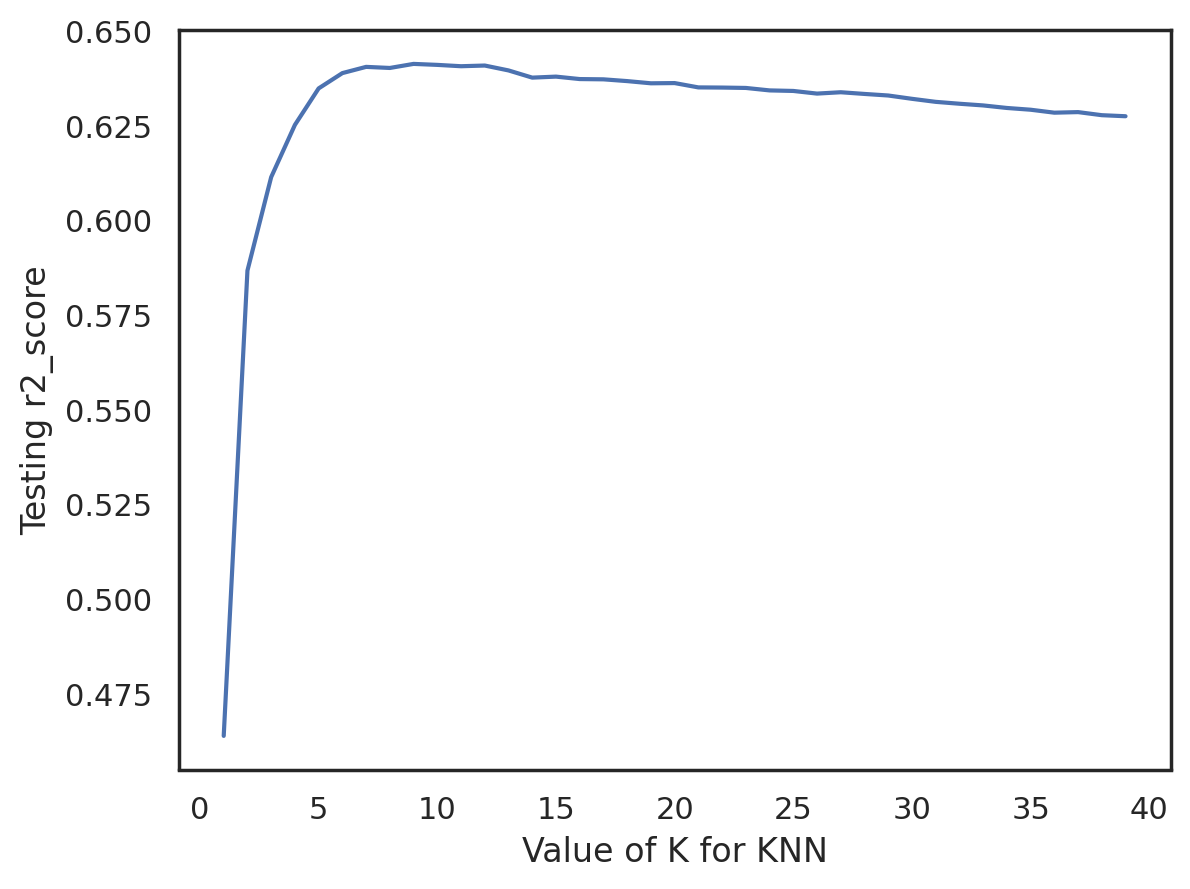

In [117]:
# import Matplotlib (scientific plotting library)
import matplotlib.pyplot as plt

# allow plots to appear within the notebook
%matplotlib inline

# try K=1 through K=40 and record testing accuracy
k_range = range(1, 40)

# We can create Python dictionary using [] or dict()
scores = []

# We use a loop through the range 1 to 40
# We append the scores in the dictionary
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance', p=1)
    y_=knn.fit(X_train, y_train).predict(X_test)
    scores.append(metrics.r2_score(y_test, y_))
# plot the relationship between K and testing r2_score
# plt.plot(x_axis, y_axis)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing r2_score')

Nhìn biểu đồ ta nhận thấy giá trị k=9 là giá trị tốt nhất có thể!

# **LIGHTGBM**

In [120]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

In [121]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 100000
}

In [122]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(**hyper_params)

In [123]:
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9711]	valid_0's l1: 6.4013e+08	valid_0's l2: 1.14683e+18
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9712]	valid_0's l1: 6.40131e+08	valid_0's l2: 1.14685e+18
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9713]	valid_0's l1: 6.40133e+08	valid_0's l2: 1.14693e+18
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9714]	valid_0's l1: 6.40138e+08	valid_0's l2: 1.147e+18
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9715]	valid_0's l1: 6.4014e+08	valid_0's l2: 1.14707e+18
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9716]	valid_0's l1: 6.40132e+08	valid_0's l2: 1.14706e+18
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9717]	valid_0's l1: 6.40126e+08	valid_0's l2: 1.14705e+18
[LightGBM

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_bin=512, max_depth=8,
              metric=['l1', 'l2'], num_iterations=100000, num_leaves=128,
              objective='regression', task='train', verbose=0)

In [124]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

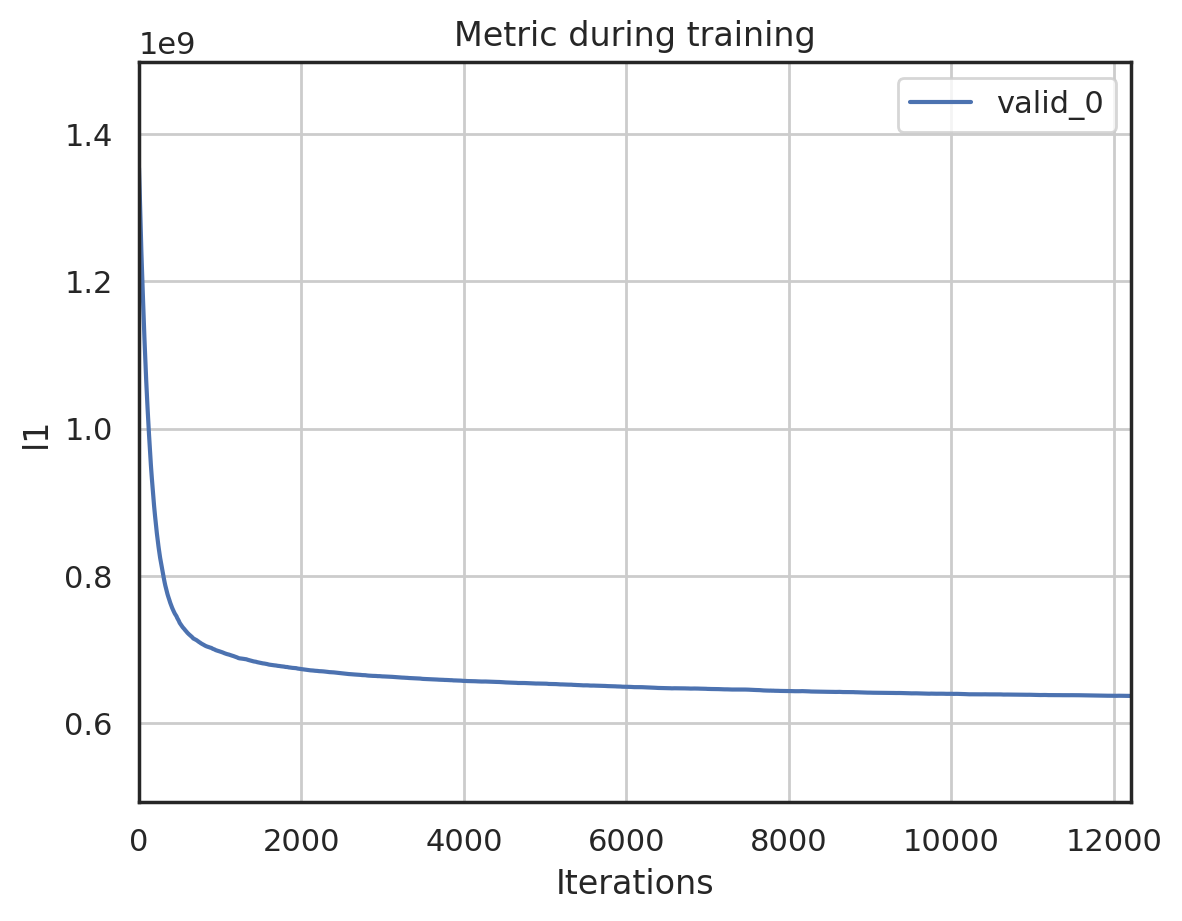

In [125]:
lgb.plot_metric(gbm.evals_result_, metric='l1')
plt.show()

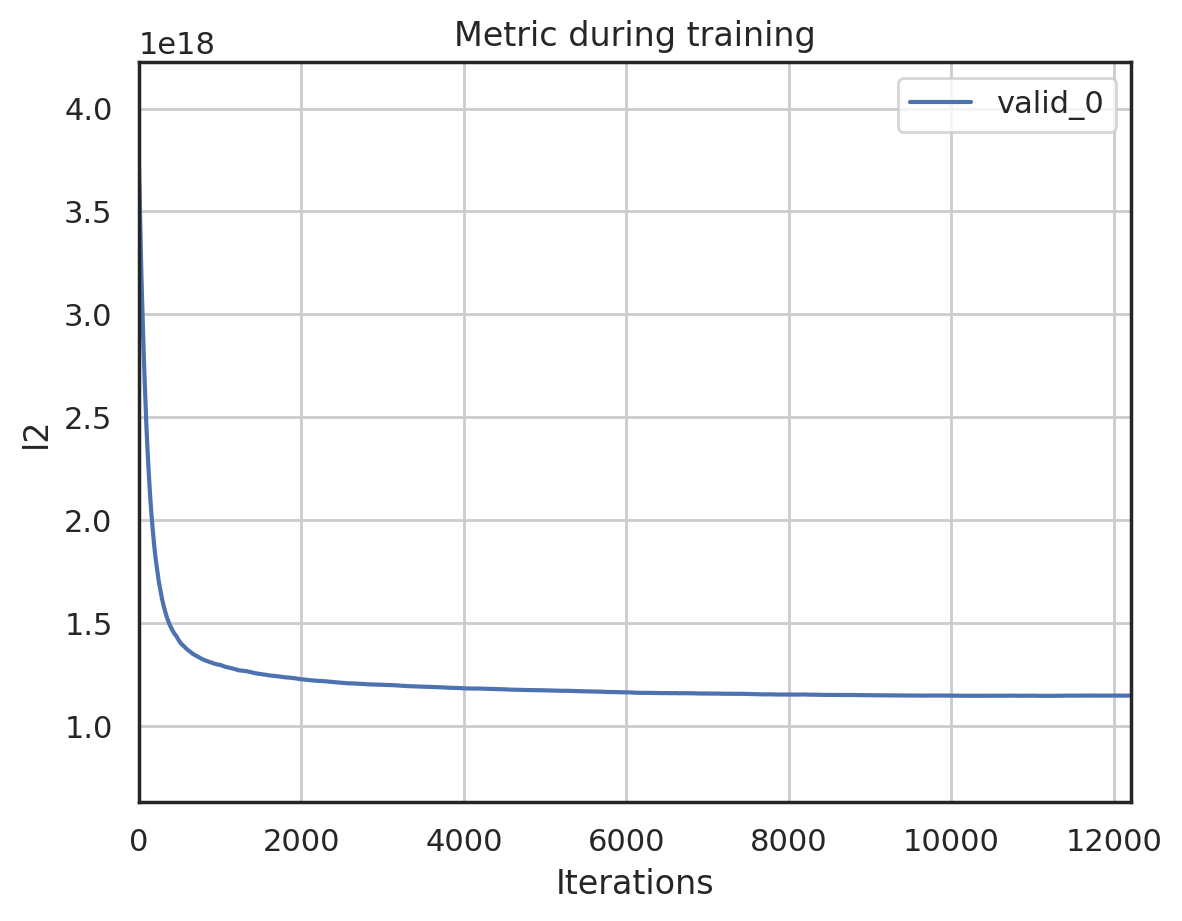

In [127]:
lgb.plot_metric(gbm.evals_result_, metric='l2')
plt.show()

In [128]:
from sklearn.metrics import mean_squared_log_error
# print('The rmse of prediction is:', round(mean_squared_log_error(y_pred, y_train) ** 0.5, 5))
print('Mean squared error: %.2f'% mean_squared_error(y_test, y_pred, squared=False))
print('R2_score: %.4f'% r2_score(y_test, y_pred))

Mean squared error: 1070228316.00
R2_score: 0.6930


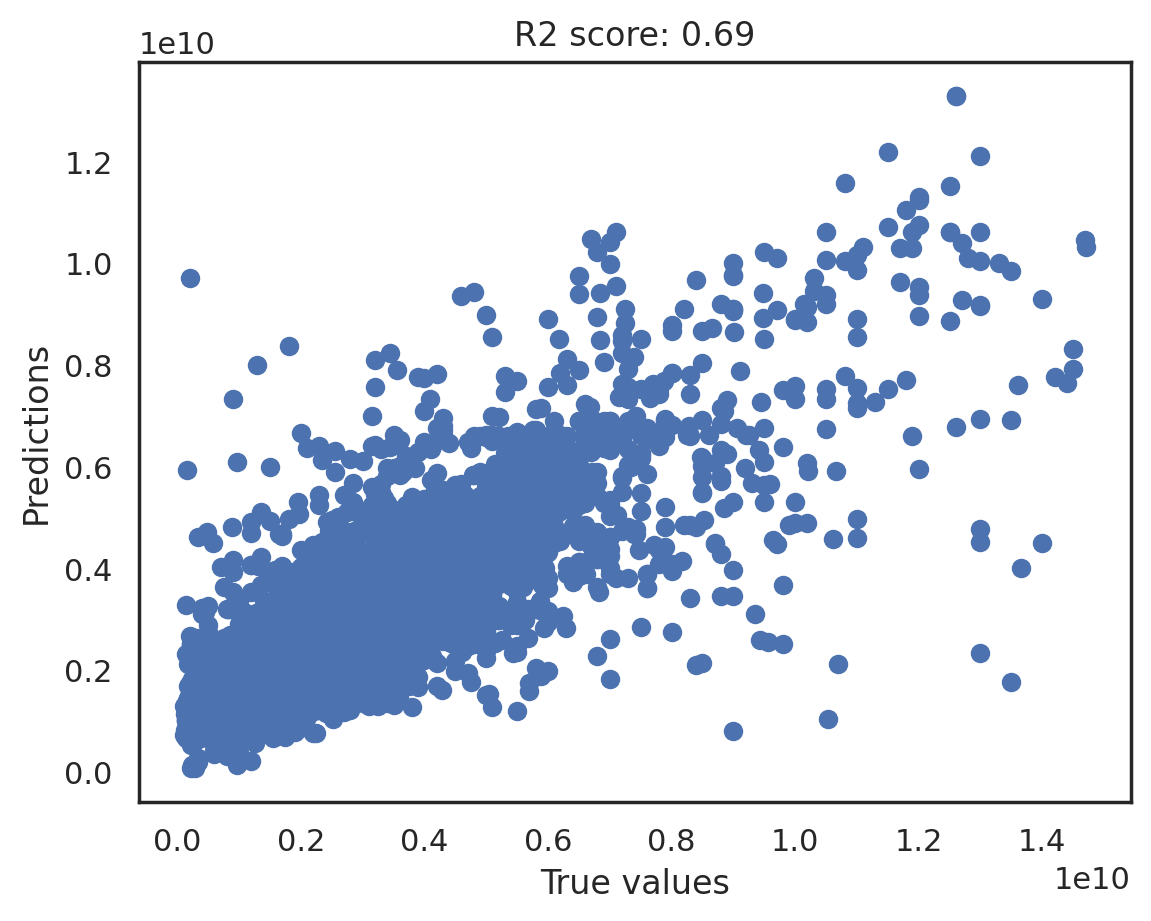

In [129]:
plt.scatter(y_test, y_pred)
plt.xlabel("True values")
plt.ylabel("Predictions")
plt.title("R2 score: {:.2f}".format(r2_score(y_test, y_pred)))
plt.show()

# **Dự đoán thử nghiệm 1 bản ghi**

In [172]:
X_train,X_test,y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=110)

In [173]:
#Thông số bản ghi đang cho vào để kiểm tra
X_test[1:2]

,square,floor,bathroom,bedroom,district,province,ward
24456,100.0,13,0.0,0,37,17,229


In [174]:
# Giá thực tế của bản ghi
y_test[1:2]

,price
24456,4.000000e+09


In [175]:
# Giá trị dự đoán qua mô hình KNN
knn = KNeighborsRegressor(n_neighbors=9, weights='distance', p=1)
y_pred = knn.fit(X_train, y_train).predict(X_test[1:2])
y_pred

array([[3.71956522e+09]])

In [176]:
# Giá trị dự đoán qua mô hình lightGBM
y_pred = gbm.predict(X_test[1:2], num_iteration=gbm.best_iteration_)
y_pred

array([4.28731761e+09])

# **Lưu mô hình sau khi dự doán**

In [177]:
import pickle
#Lưu mô hình KNN
with open('/content/drive/MyDrive/Colab/DATN/data-modeling/knn_model_ver4.pkl', 'wb') as file:
    pickle.dump(knn, file)
#Lưu mô hình LightGBM
with open('/content/drive/MyDrive/Colab/DATN/data-modeling/gbm_model_ver4.pkl', 'wb') as file:
    pickle.dump(gbm, file)
import os

save_dir = '/content/drive/MyDrive/Colab/DATN/data-modeling/'
# Train your LabelEncoder objects and transform the data
lbl = {c: LabelEncoder().fit(df[c]) for c in cols}

os.makedirs(save_dir, exist_ok=True)
# Save the LabelEncoder objects to files
for c in cols:
    with open(os.path.join(save_dir, f'{c}_label_encoder_ver4.pkl'), 'wb') as file:
        pickle.dump(lbl[c], file)

Kiểm tra mô hình KNN đã lưu

In [178]:
import joblib
import os
import pickle

#Lưu mô hình KNN
with open('/content/drive/MyDrive/Colab/DATN/data-modeling/knn_model_ver3.pkl', 'rb') as file:
    knn2 = pickle.load(file)
input = {
    'square': 100,
    'floor': 12,
    'bathroom': 2,
    'bedroom': 3,
    'district': ['Bắc Từ Liêm'],
    'province': ['Hà Nội'],
    'ward': ['Đức Thắng']
}
# Define the directory path where the files are saved
save_dir = '/content/drive/MyDrive/Colab/DATN/data-modeling/'

# Load the LabelEncoder objects from files
lbl = {}
cols = ['district', 'province', 'ward']
for c in cols:
    with open(os.path.join(save_dir, f'{c}_label_encoder_ver3.pkl'), 'rb') as file:
        lbl[c] = pickle.load(file)

# Create a sample DataFrame from the input_data dictionary
sample_transformed = pd.DataFrame()
for c in cols:
    if c in input:
        # Check if the input data contains new values that were not in the training data
        new_values = list(set(input[c]) - set(lbl[c].classes_))
        if new_values:
            # Add the new values to the LabelEncoder classes and transform the input data
            lbl[c].classes_ = np.concatenate((lbl[c].classes_, new_values))
        sample_transformed[c] = lbl[c].transform(input[c])
cols_num = ['square', 'floor', 'bathroom', 'bedroom']
for c in cols_num:
    sample_transformed[c] = float(input[c])
column_order = ['square', 'floor', 'bathroom','bedroom', 'district', 'province', 'ward']
sample_transformed = sample_transformed.reindex(columns=column_order)
y_pred = knn2.predict(sample_transformed[0:1])
y_pred

array([[3.41474619e+09]])

Kiểm tra mô hình LightGBM đã lưu

In [179]:
import pickle
import os

with open('/content/drive/MyDrive/Colab/DATN/data-modeling/gbm_model_ver3.pkl', 'rb') as file:
    gbm2 = pickle.load(file)
input = {
    'square': 100,
    'floor': 12,
    'bathroom': 2,
    'bedroom': 3,
    'district': ['Bắc Từ Liêm'],
    'province': ['Hà Nội'],
    'ward': ['Đức Thắng']
}
# Define the directory path where the files are saved
save_dir = '/content/drive/MyDrive/Colab/DATN/data-modeling/'

# Load the LabelEncoder objects from files
lbl = {}
cols = ['district', 'province', 'ward']
for c in cols:
    with open(os.path.join(save_dir, f'{c}_label_encoder_ver3.pkl'), 'rb') as file:
        lbl[c] = pickle.load(file)

# Create a sample DataFrame from the input_data dictionary
sample_transformed = pd.DataFrame()
for c in cols:
    if c in input:
        # Check if the input data contains new values that were not in the training data
        new_values = list(set(input[c]) - set(lbl[c].classes_))
        if new_values:
            # Add the new values to the LabelEncoder classes and transform the input data
            lbl[c].classes_ = np.concatenate((lbl[c].classes_, new_values))
        sample_transformed[c] = lbl[c].transform(input[c])
cols_num = ['square', 'floor', 'bathroom', 'bedroom']
for c in cols_num:
    sample_transformed[c] = float(input[c])
column_order = ['square', 'floor', 'bathroom','bedroom', 'district', 'province', 'ward']
sample_transformed = sample_transformed.reindex(columns=column_order)
y_pred = gbm2.predict(sample_transformed[0:1], num_iteration=gbm2.best_iteration_)
y_pred

array([3.42208728e+09])